In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = pd.read_csv('transformer_data.csv')

# Preliminary data analisys

In [2]:

data

,time,Y,Ta,S,I
0,1,23.496733,7.083333,0.0,15.899541
1,2,22.720333,7.116667,0.0,15.861768
2,3,22.052700,7.216667,0.0,16.121469
3,4,21.538050,7.250000,0.0,15.447628
4,5,20.995033,7.316667,0.0,16.258319
...,...,...,...,...,...
163,164,31.510183,14.350000,157.5,16.000643
164,165,30.037760,12.166667,29.0,16.005937
165,166,28.530450,10.283333,0.0,16.427983
166,167,27.118660,8.700000,0.0,16.370292


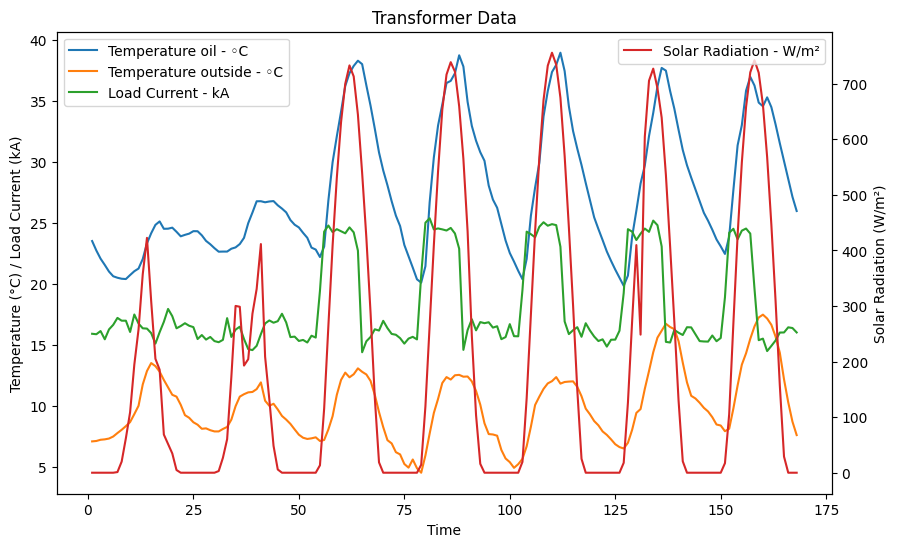

In [3]:


fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis
ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C) / Load Current (kA)")
ax1.legend(loc='upper left')

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc='upper right')

plt.title("Transformer Data")
plt.show()

### Briefly comment on patterns, trends, or correlations you observe.
• Hint: Look for relationships between temperature, outdoor conditions, and load.

You could initially think the oil temperature is rising because of solar radition, or the load is simply correlated with people using more power during the day hours where there is a higher outside temperature and more solar radition because the sun is out. How ever it seem that the load is much more coorelated with the sun radition, since load is not consistent with time of day (and outside temperature). You could speculate since there is such a strong correlation with solar radiation that the transformer station is connected to a solar farm and subsequently delivers (and transforms) much more power when the sun is out, and that the significant increases in oil heat is mostly correlated with load and not the outside temperature being hotter outside due to the sun being out.


# 1d Model

In [4]:
import importlib
import utils
importlib.reload(utils)
from utils import estimate_dt_1d, return_1d_params, kf_log_likelihood_1d

In [5]:
results = estimate_dt_1d(df=data)
params = results.x


In [6]:
print([param for param in zip(['A', 'B', 'sigma_1', 'C', 'sigma_2'],return_1d_params(params))])

[('A', 0.80109252692634), ('B', array([[0.09886138, 0.0027931 , 0.20723195]])), ('sigma_1', 0.3893070058984917), ('C', 1.0295632982582998), ('sigma_2', 0.001)]


final Log Likelihood -1d model: [[164.26363752]]


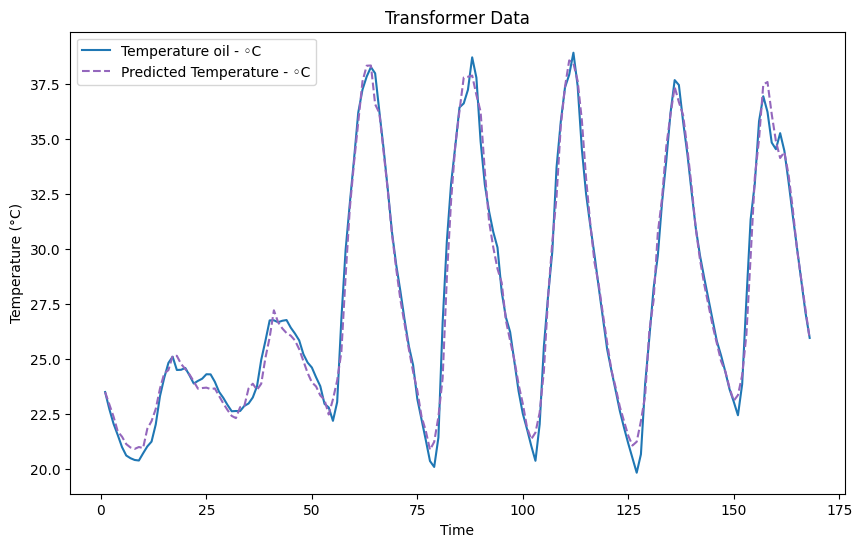

In [7]:
log_lik, y_predicted, x_filtered_1D = kf_log_likelihood_1d(params, data, return_all=True)
print(f"final Log Likelihood -1d model: {log_lik}")
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis
ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
# ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
# ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.plot(data["time"], y_predicted, label="Predicted Temperature - ◦C", color='tab:purple', linestyle='--')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C)")
ax1.legend(loc='upper left')

# # Second y-axis
# ax2 = ax1.twinx()
# ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
# ax2.set_ylabel("Solar Radiation (W/m²)")
# ax2.legend(loc='upper right')

plt.title("Transformer Data")
plt.show()




AIC: -134.3871382290996, BIC: -112.51939037327679


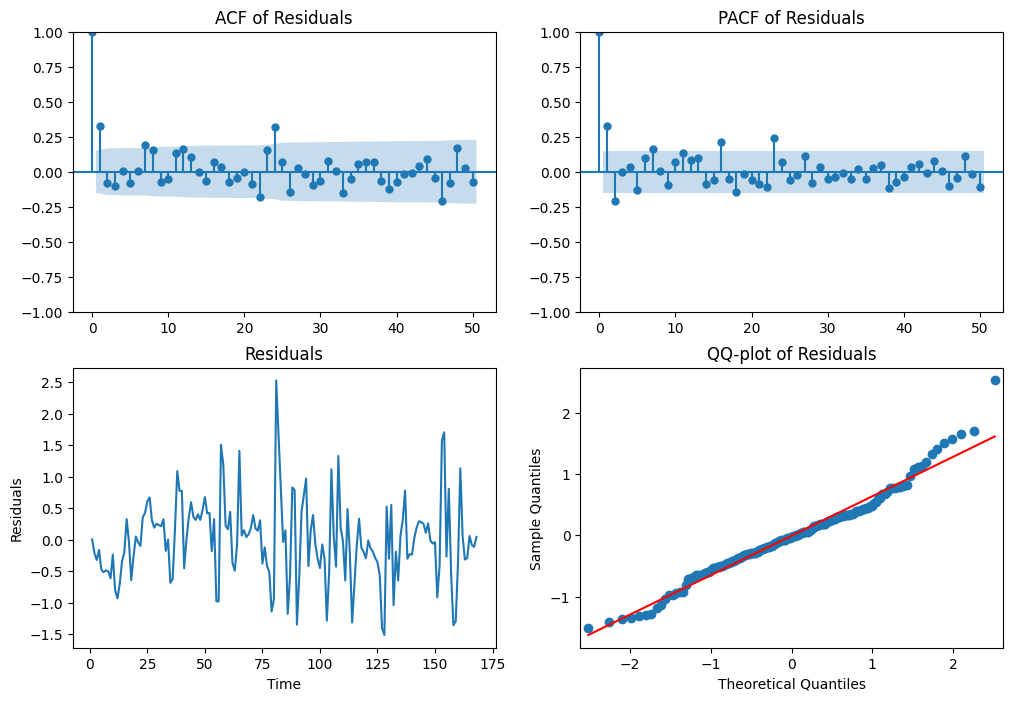

In [8]:
import importlib
import utils
importlib.reload(utils)
from utils import plots_and_stats

plots_and_stats(data, y_predicted)

# 2d model

In [9]:
import importlib
import utils
importlib.reload(utils)
import utils
from utils import estimate_dt_2d, return_2d_params, kf_log_likelihood_2d, plots_and_stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = pd.read_csv('transformer_data.csv')

In [10]:
results = estimate_dt_2d(df=data)
params = results.x


In [11]:
for param in zip(['A', 'B', 'sigma_1', 'C', 'sigma_2'],return_2d_params(params)):
    print(param[0])
    print(param[1])

log_lik, y_predicted_2d, x_filtered_2D = kf_log_likelihood_2d(params, data, return_all=True)

print("Final log likelihood -2d model:", log_lik)


A
[[0.36679538 0.67451084]
 [0.15124237 0.43802385]]
B
[[-0.1136303   0.00043606 -0.07556059]
 [ 0.23434064  0.00259473  0.40493282]]
sigma_1
[[0.00234204 0.03493833]
 [0.03493833 0.75602228]]
C
[[0.89379523 0.3364572 ]]
sigma_2
0.021160389213477557
Final log likelihood -2d model: 124.05460649815998


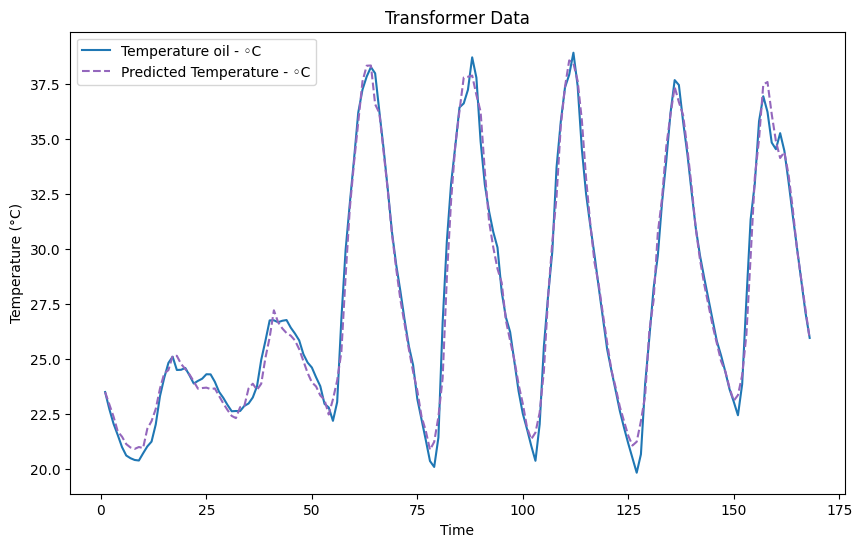

In [12]:

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')

ax1.plot(data["time"], y_predicted, label="Predicted Temperature - ◦C", color='tab:purple', linestyle='--')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C)")
ax1.legend(loc='upper left')


plt.title("Transformer Data")
plt.show()




AIC: -116.3871382290996, BIC: -66.40371455864747


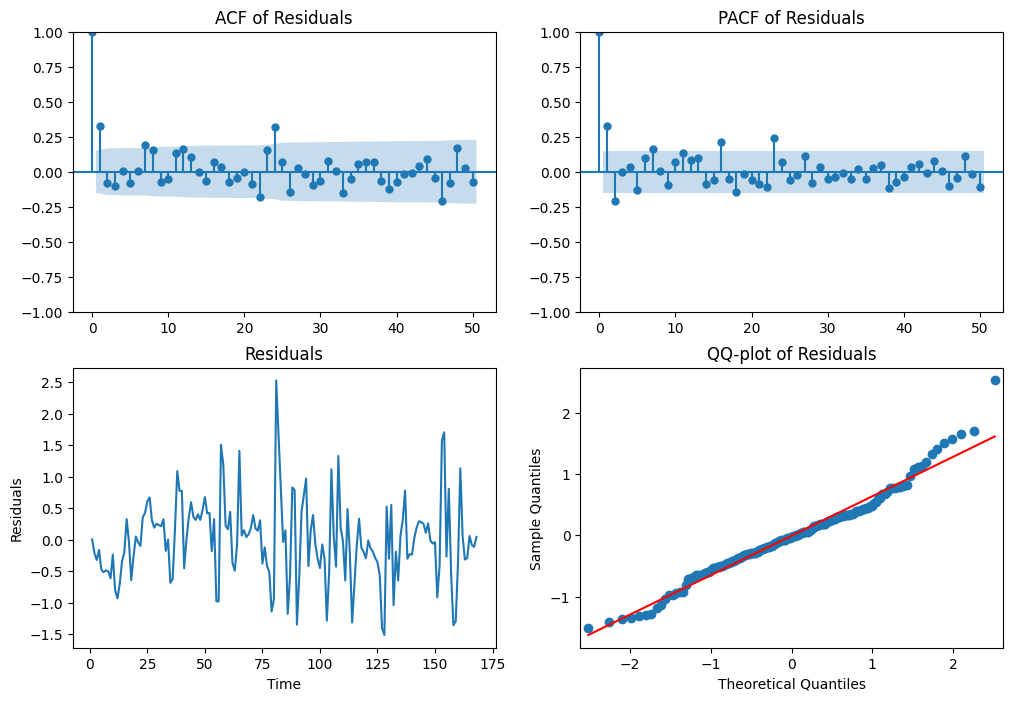

In [13]:
plots_and_stats(data, y_predicted, k=16)

# State comparison

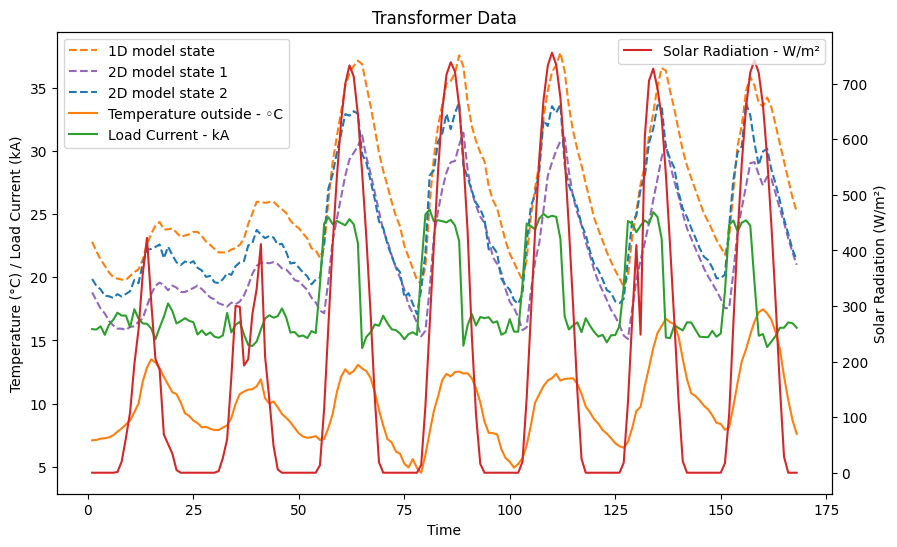

In [21]:


fig, ax1 = plt.subplots(figsize=(10, 6))

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(data["time"], data["S"], label="Solar Radiation - W/m²", color='tab:red')
ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc='upper right')

# First y-axis
ax1.plot(data["time"], x_filtered_1D, label="1D model state", color='tab:orange', linestyle='--')
ax1.plot(data["time"], x_filtered_2D[:,0], label="2D model state 1", color='tab:purple', linestyle='--')
ax1.plot(data["time"], x_filtered_2D[:,1], label="2D model state 2", color='tab:blue', linestyle='--')


#ax1.plot(data["time"], data["Y"], label="Temperature oil - ◦C", color='tab:blue')
ax1.plot(data["time"], data["Ta"], label="Temperature outside - ◦C", color='tab:orange')
ax1.plot(data["time"], data["I"], label="Load Current - kA", color='tab:green')
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (°C) / Load Current (kA)")
ax1.legend(loc='upper left')


plt.title("Transformer Data")
plt.show()